In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from stepbystep.v0 import StepByStep
from plots.ch_3 import *

## A Simple Classification Problem ##

**Data Generation**

In [2]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [3]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

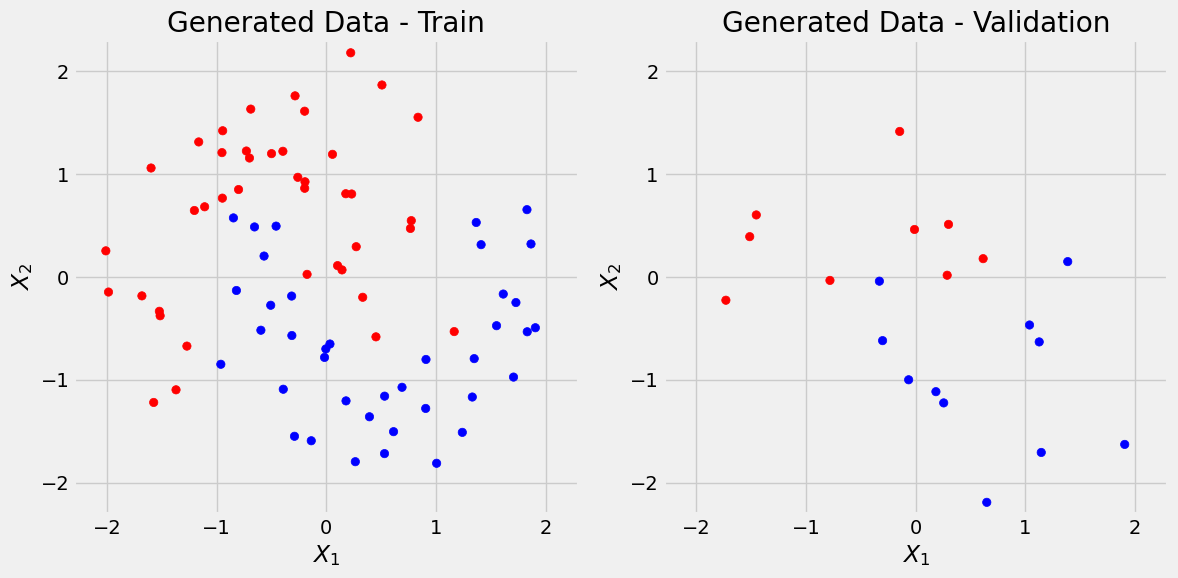

In [4]:
fig = figure1(X_train, y_train, X_val, y_val)

**Data Preparation**

In [5]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [6]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [7]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

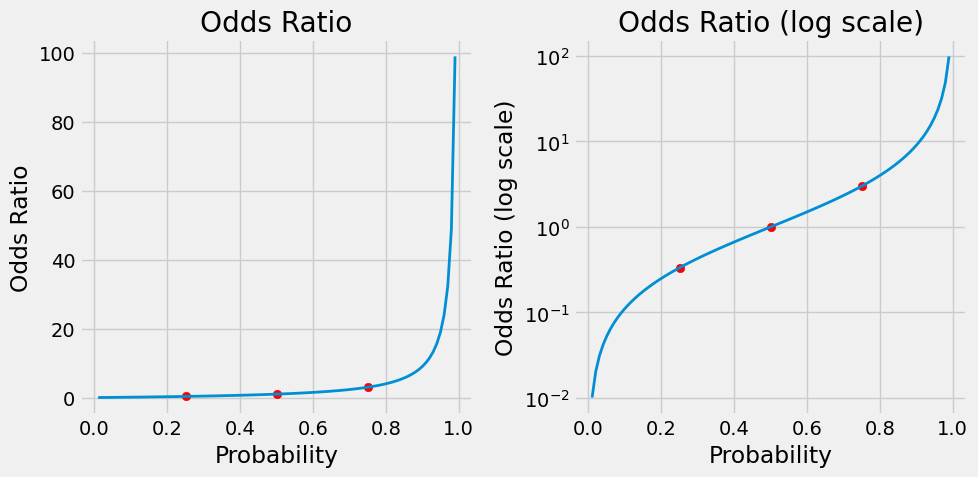

In [8]:
fig = figure2(p)

In [9]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

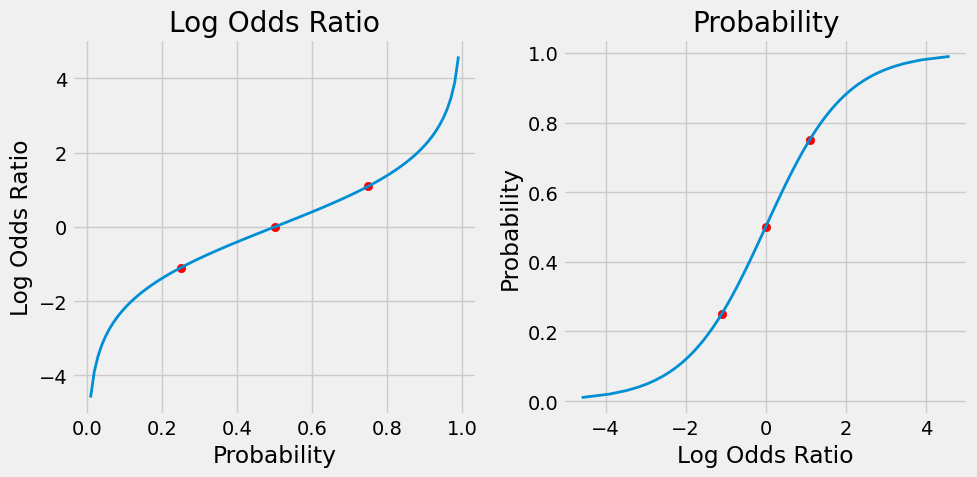

In [10]:
fig = figure3(p)

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

**Sigmoid**

In [12]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

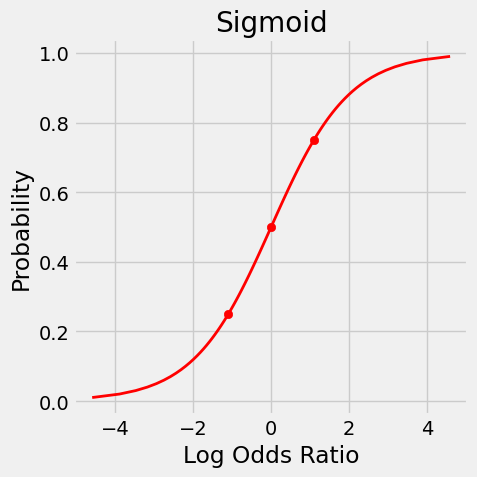

In [13]:
fig = figure4(p)

In [14]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2,1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


In [15]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (lables == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1-negative_pred).sum()
# n_total = n_po + n_neg
n_total = dummy_labels.size(0)
loss = -(first_summation + second_summation)/n_total
loss

tensor(0.1643)

In [16]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) + (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = - summation / n_total
loss

tensor(0.1643)

**BCELoss**

In [17]:
loss_fn = nn.BCELoss(reduction='mean')
loss_fn

BCELoss()

In [18]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)
print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


**BCEWithLogitsLoss**

In [19]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')
loss_fn_logits

BCEWithLogitsLoss()

In [20]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [21]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

**Imbalanced Dataset**

In [22]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

In [23]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

In [25]:
pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

In [26]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

In [27]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

In [28]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration ##

In [29]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()


## Model Training ##

In [31]:
n_epochs = 100
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

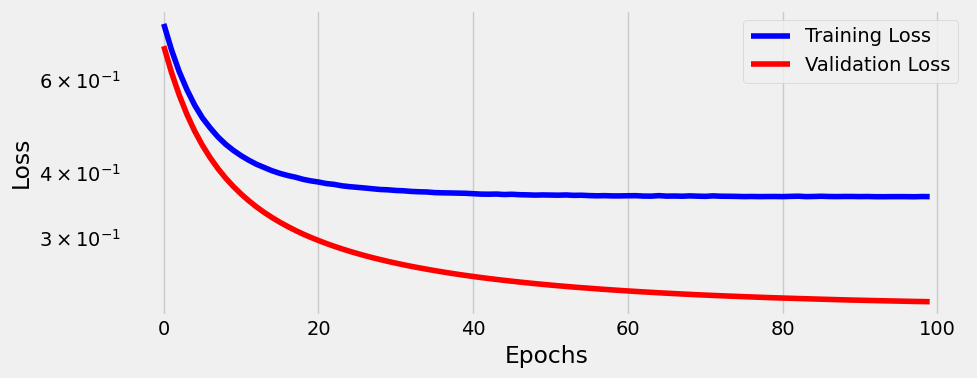

In [32]:
fig = sbs.plot_losses()

In [33]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]], device='cuda:0')), ('linear.bias', tensor([-0.0591], device='cuda:0'))])


**Making Predictions (Logits)**

In [34]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345594],
       [ 2.9444456 ],
       [ 3.693318  ],
       [-1.2334074 ]], dtype=float32)

**Making Predictions (Probabilities)**

In [35]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892],
       [0.9500003],
       [0.9757152],
       [0.2255856]], dtype=float32)

In [36]:
classes = (predictions >= 0).astype(int)
classes

array([[1],
       [1],
       [1],
       [0]])

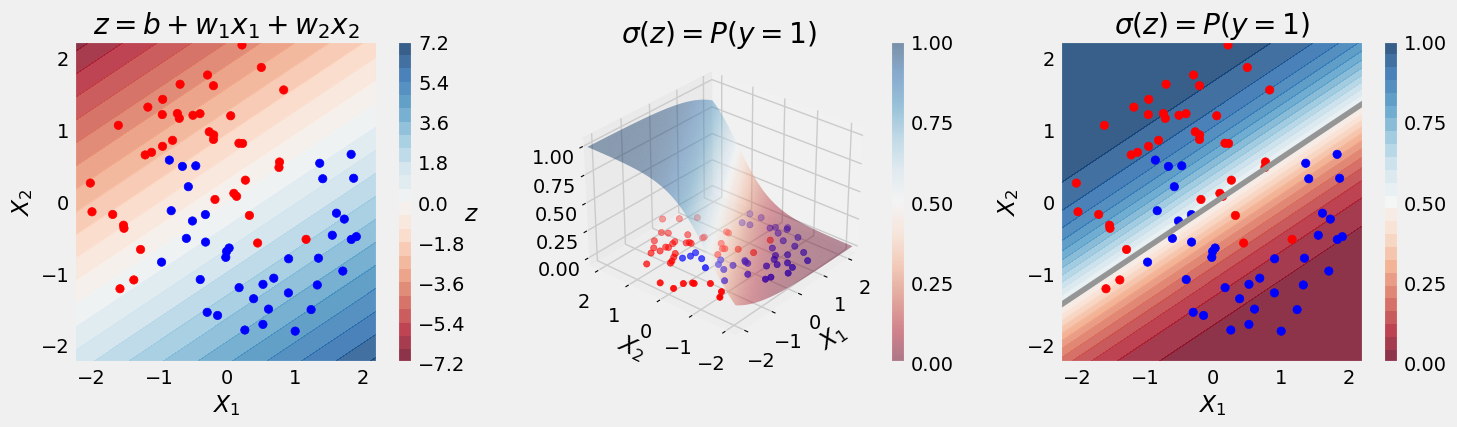

In [37]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

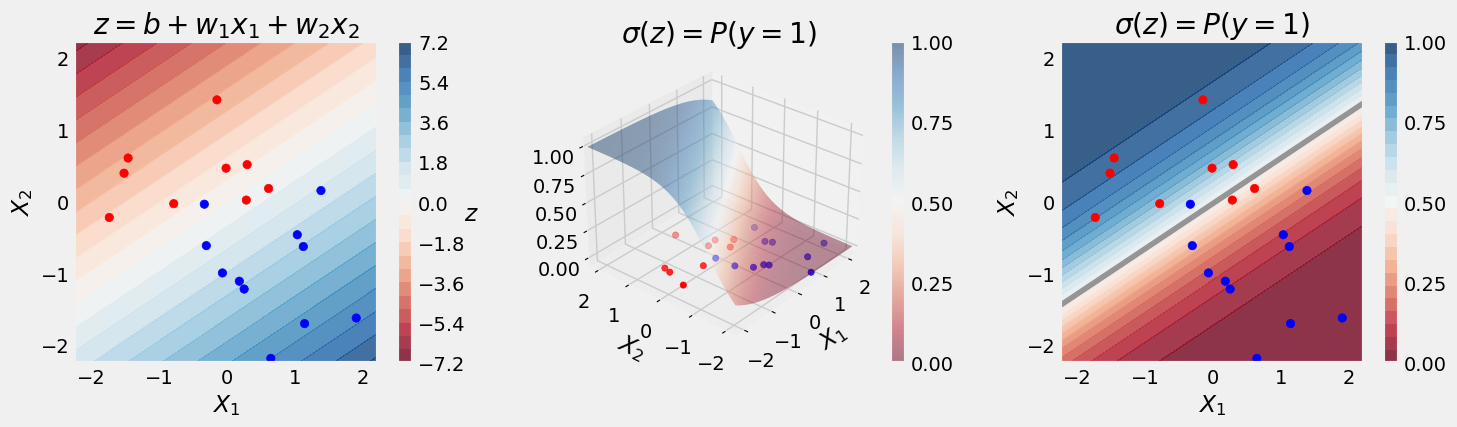

In [40]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

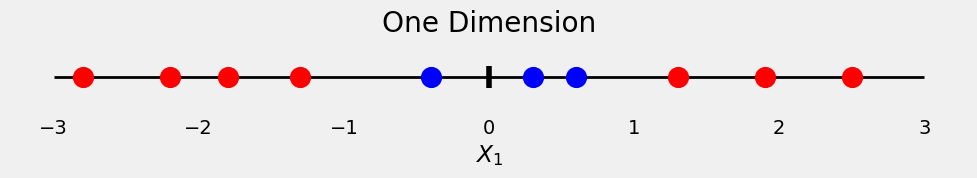

In [41]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

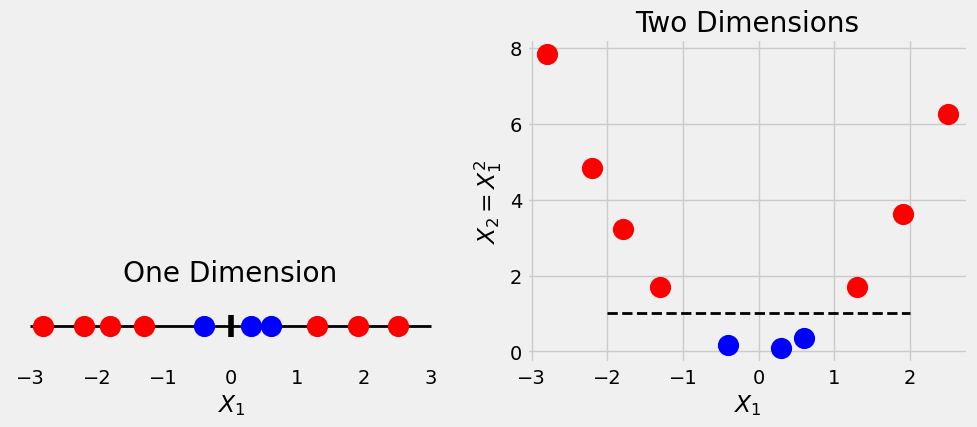

In [42]:
fig = two_dimensions(x, y)

In [43]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

## Classification Threshold ##

In [44]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

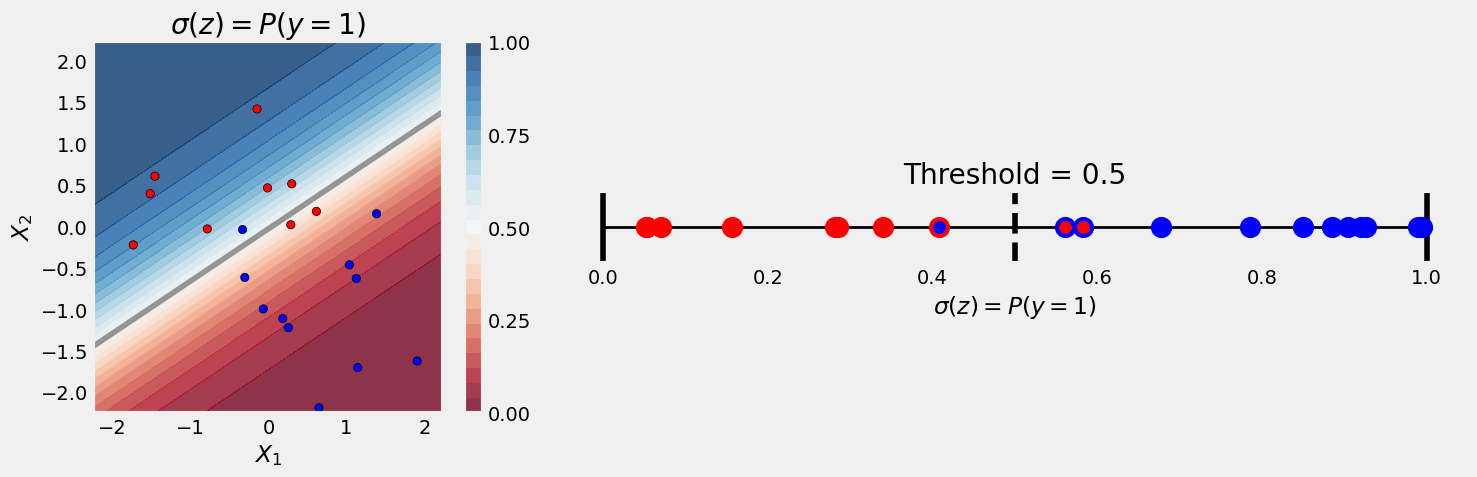

In [45]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

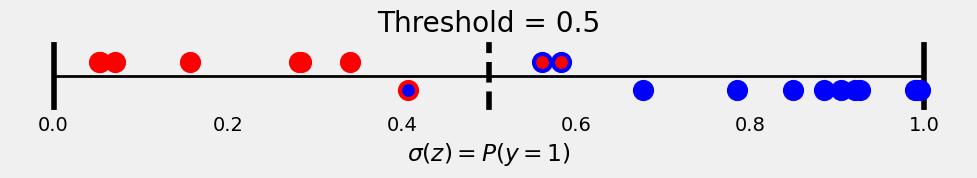

In [46]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

**Confusion Matrix**

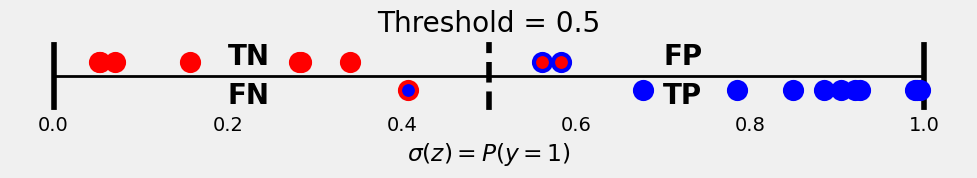

In [47]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [48]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

**True and False Positives and Negatives**

In [49]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

**Metrics**

In [50]:
# True and False Positive Rates
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [51]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

In [52]:
# Precision and Recall
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [53]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

**Accuracy**

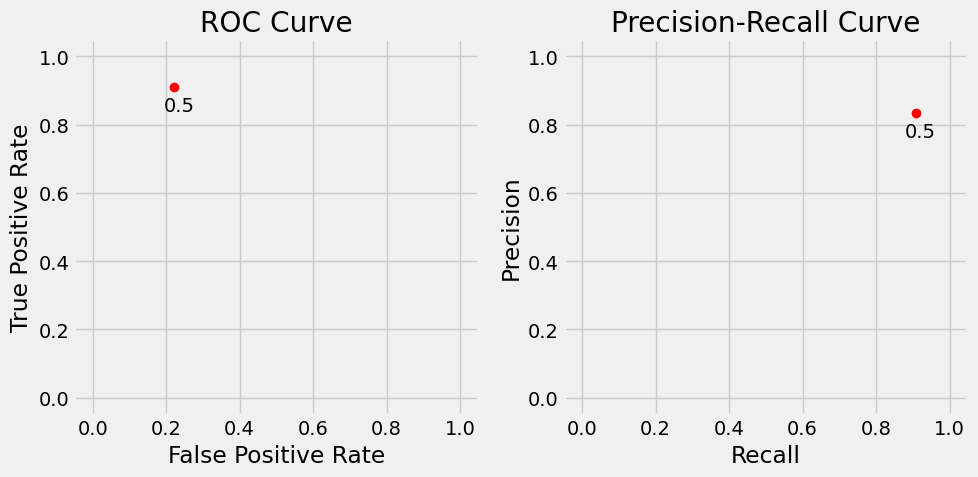

In [54]:
# Trade-offs and Curves
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)


**Low Threshold**

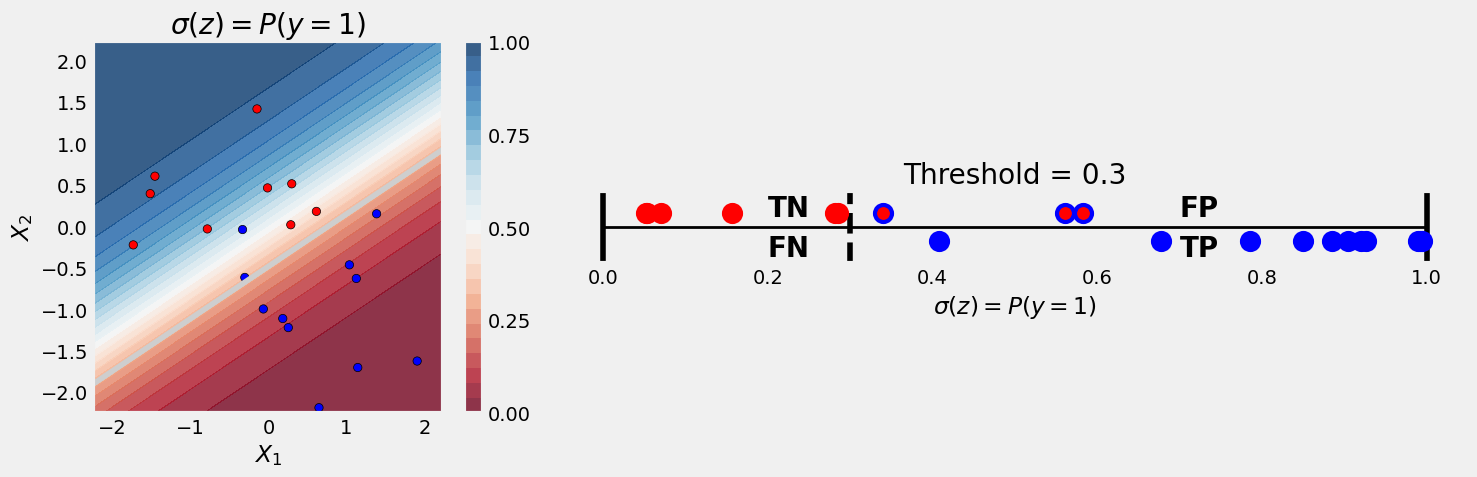

In [55]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)


In [56]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

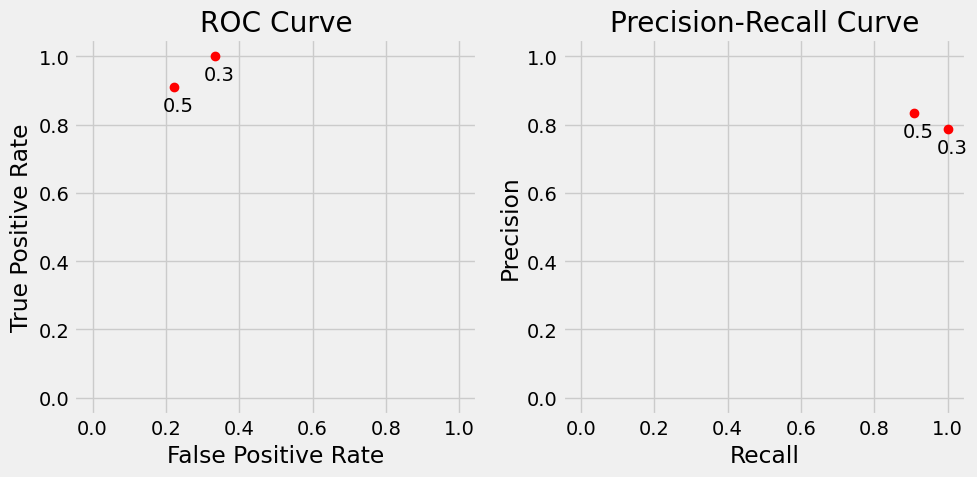

In [57]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)


**High Threshold**

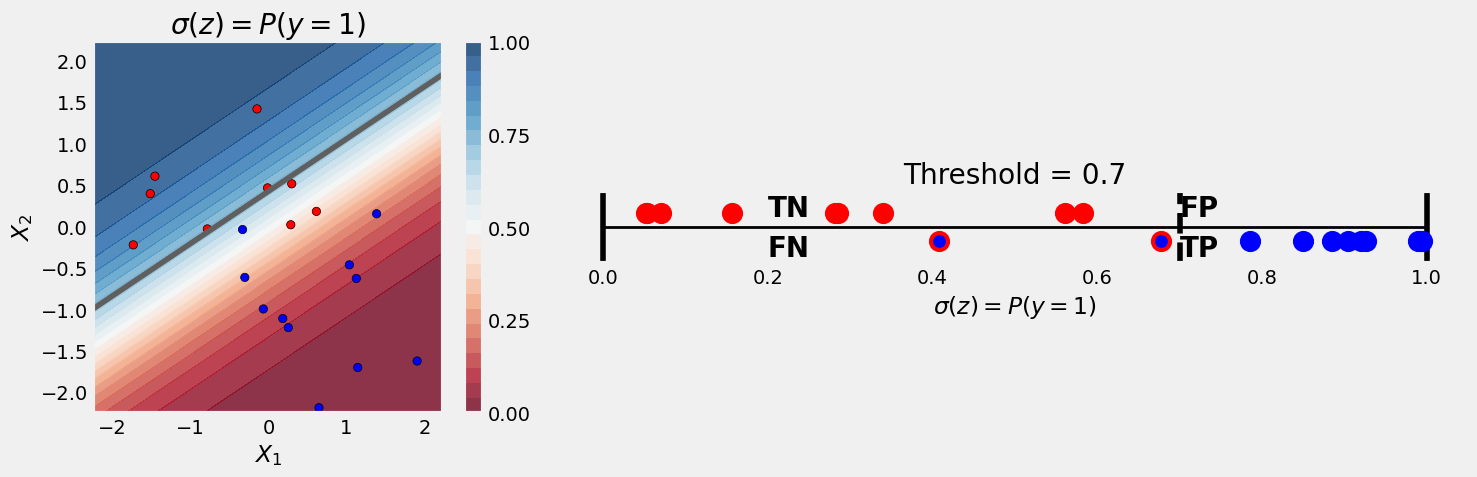

In [58]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)


In [59]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

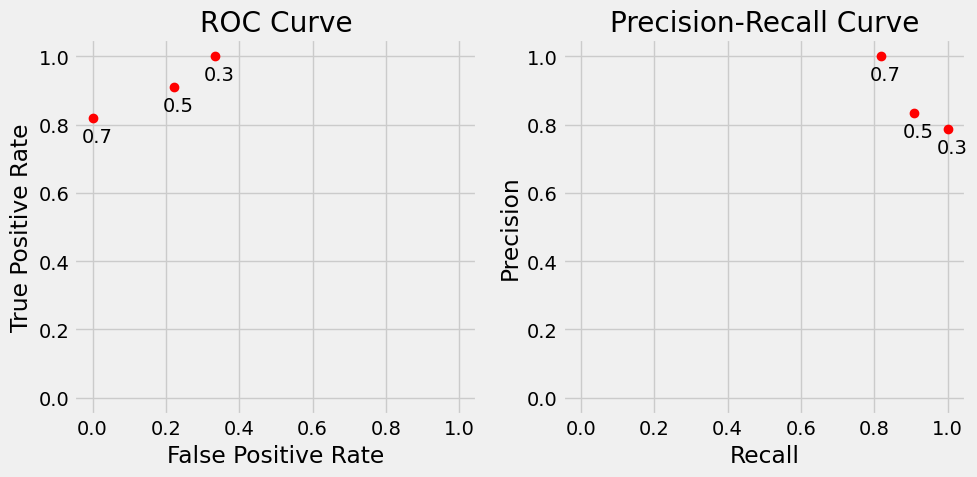

In [60]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)


**ROC and PR Curves**

In [61]:
threshs = np.linspace(0.,1,11)

/home/kazi/Works/Projects/pytorch-deep/plots/ch_3.py:56: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


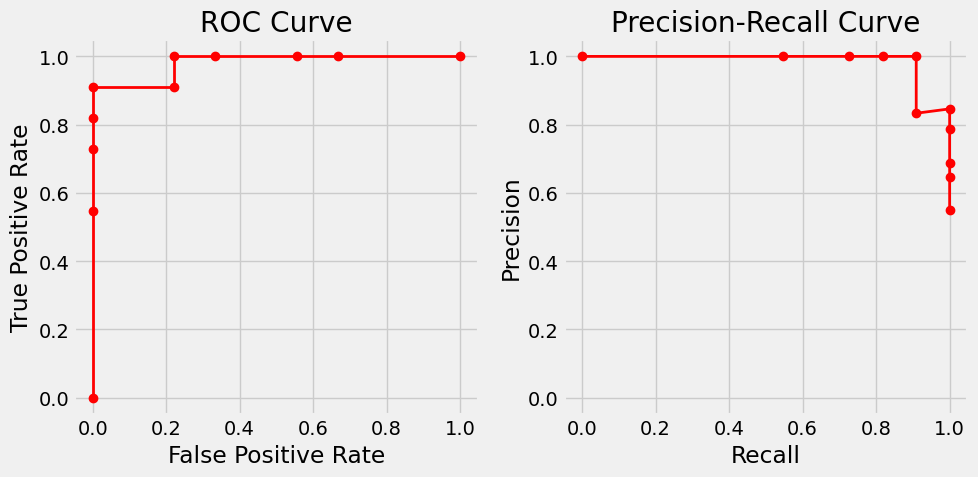

In [62]:
fig = figure17(y_val, probabilities_val, threshs)

In [63]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

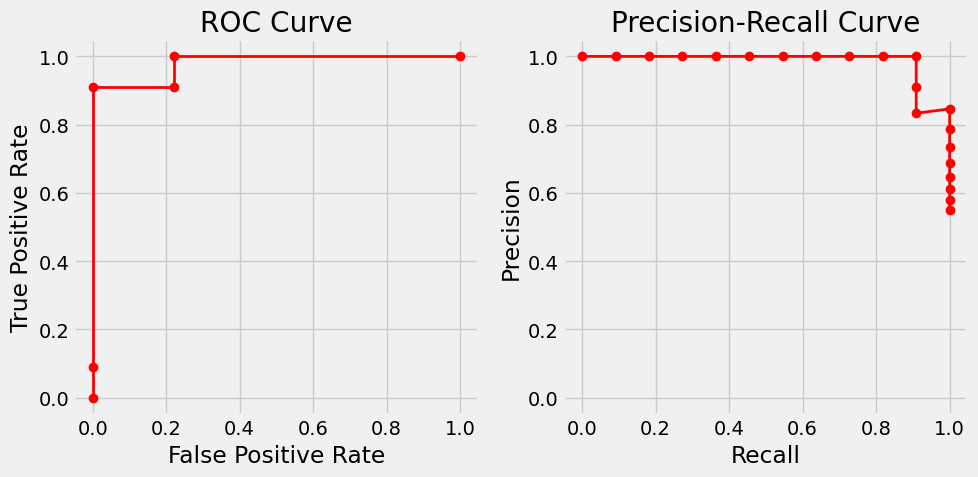

In [64]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)


**The Precision Quirk**

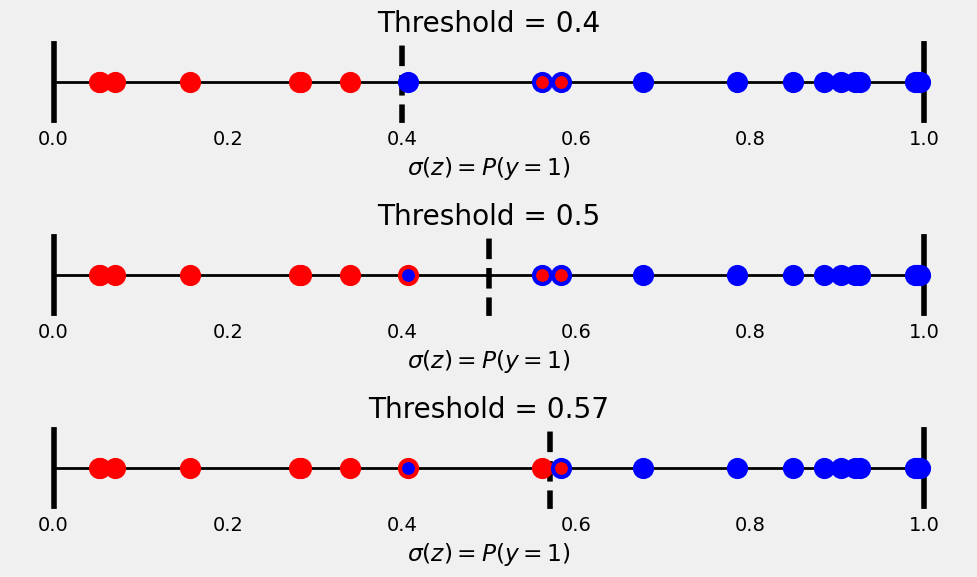

In [65]:
fig = figure19(y_val, probabilities_val)

**Best and Worst Curves**

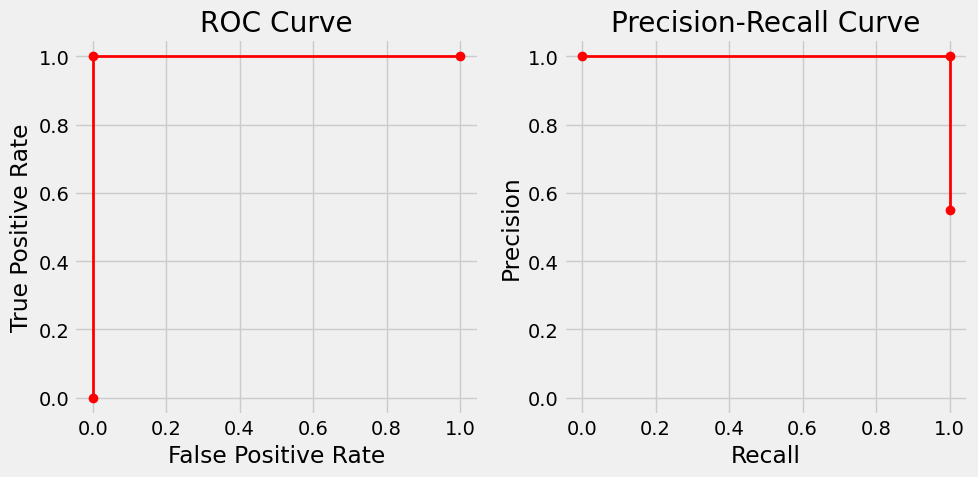

In [66]:
# Best
fig = figure20(y_val)

In [67]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [68]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)


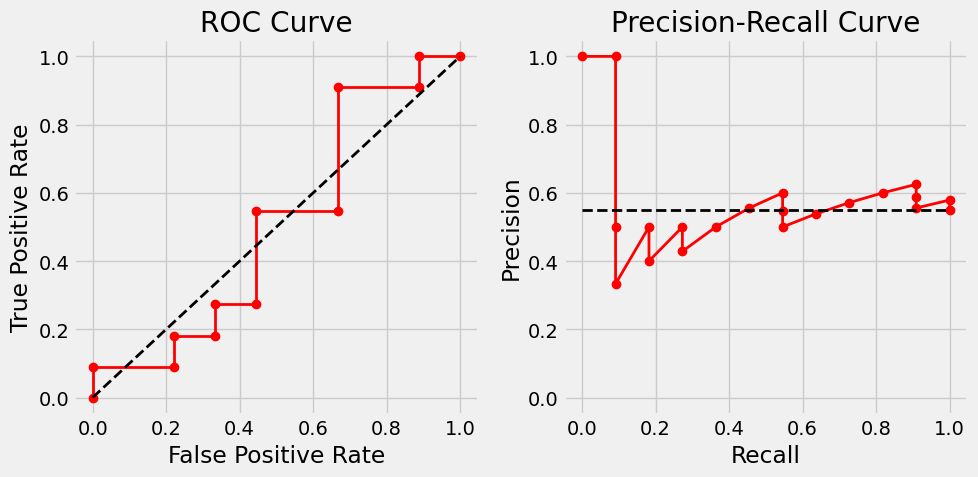

In [69]:
# Worst
fig = figure21(y_val, random_probs)

## Comparing Models ## 

In [70]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


In [71]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941
